In [1]:
import openmc as mc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# create materials
uranium = mc.Material(1, "natural uranium")
uranium.add_nuclide('U238', 99.8, 'wo')
uranium.add_nuclide('U235', 0.2, 'wo')
uranium.add_nuclide('U234', 0.001, 'wo')
uranium.deplete = True

zirconium = mc.Material(2, "zirconium")
zirconium.add_element('Zr',1,'wo')

plutonium = mc.Material(3, "plutonium")
plutonium.add_nuclide('Pu238', 3.18, 'wo')
plutonium.add_nuclide('Pu239', 56.35, 'wo')
plutonium.add_nuclide('Pu240', 26.6, 'wo')
plutonium.add_nuclide('Pu241', 8.02, 'wo')
plutonium.add_nuclide('Pu242', 5.83, 'wo')
plutonium.deplete = True

upz = mc.Material.mix_materials([uranium, plutonium, zirconium], [0.8, 0.1, 0.1], 'wo')
upz.set_density('g/cc', 11.88)
upz.temperature = 700

In [3]:
lbe = mc.Material(5, "lead-bismuth-eutectic")

lbe.add_element('Pb', 44.5, 'wo')
lbe.add_element('Bi', 55.5, 'wo')

lbe.set_density('g/cc', 10.3)
lbe.temperature = 620.15

In [4]:
steel = mc.Material(6, "15-15Ti Steel")

steel.add_nuclide('C12', 0.090, 'wo')
steel.add_nuclide('Mn55', 1.502, 'wo')
steel.add_nuclide('Si28', 0.791, 'wo')
steel.add_nuclide('P31', 0.041, 'wo')

steel.add_element('Ti', 0.404, 'wo')
steel.add_element('Cr', 14.392, 'wo')
steel.add_element('Ni', 15.607, 'wo')
steel.add_element('B', 0.007, 'wo')
steel.add_element('Mo', 1.509, 'wo')

steel.set_density('g/cc', 7.92)
steel.temperature = 650

In [5]:
# volume calculation
import numpy as np
fuel_radius = 0.74
clad_radius = 0.77
# total volume of the hexagonal cylinder with edge length of 1.096965511 cm and height of 140 cm
# area of regular hexagon
area = ((np.sqrt(3) / 4) * 1.096965511 * 1.096965511) * 6
total_volume = area * 140

fuel_volume = np.pi * fuel_radius * fuel_radius * 140
clad_volume = np.pi * (clad_radius * clad_radius - fuel_radius * fuel_radius) * 140
coolant_volume = total_volume - fuel_volume - clad_volume

upz.volume = fuel_volume
lbe.volume = coolant_volume
steel.volume = clad_volume

In [6]:
mats = mc.Materials([upz, lbe, steel])
mats.export_to_xml()

In [7]:
# create geometry
ac_top = mc.ZPlane(z0=140, boundary_type='vacuum')
ac_bottom = mc.ZPlane(z0=0, boundary_type='vacuum')

fuel_radius = 0.74
clad_radius = 0.77
r_fuel = mc.ZCylinder(r= fuel_radius) 
r_clad = mc.ZCylinder(r= clad_radius)

#create hexagonal prism with parallel sides distance of 1.9
hex_region = mc.hexagonal_prism(edge_length= 1.096965511, orientation='x', boundary_type='reflective') & -ac_top & +ac_bottom


# create cells
fuel = mc.Cell(fill=upz, region=-r_fuel & +ac_bottom & -ac_top) 
clad = mc.Cell(fill=steel, region=+r_fuel & -r_clad & +ac_bottom & -ac_top)
coolant = mc.Cell(fill=lbe, region= hex_region & ~clad.region & ~fuel.region)

pin_universe = mc.Universe(cells=[fuel, clad, coolant], name="pin_for_zone") 

In [8]:
geom = mc.Geometry()
geom.root_universe = pin_universe
geom.export_to_xml()



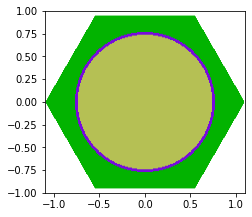

In [9]:
#default origin will not work as the domain is from 0 to 140 in z direction
pin_universe.plot(width = (2.2, 2), basis = 'xy', origin = (0, 0, 3))

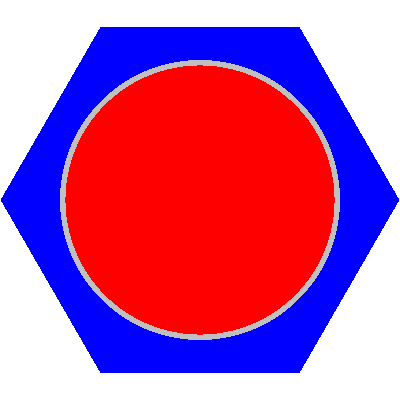

In [8]:
# core_slice for slice plot of the core
core_slice = mc.Plot()
core_slice.filename = 'coreSlice'
core_slice.color_by = 'material'
core_slice.colors = {upz: 'red', lbe: 'blue', steel: 'silver'}
core_slice.show_overlaps = True
core_slice.type = 'slice'
core_slice.width = (2.2, 2.2)
core_slice.pixels = (400, 400)
core_slice.basis = 'xy'
core_slice.origin = (0, 0, 3)
core_slice.to_ipython_image()

In [11]:
# p_core for voxel plot
p_core = mc.Plot()
p_core.filename = 'coreVoxel'
p_core.color_by = 'material'
p_core.colors = {upz: 'red', lbe: 'blue', steel: 'silver'}
p_core.show_overlaps = True
p_core.type = 'voxel'

# here width and pixels are set to visualize approximately the center assembly.
# you can increase these values to visualize the whole core
p_core.width = (2.2, 1.9, 140)
p_core.origin = (0, 0, 70)
p_core.pixels = (400, 400, 100)
p_core.depth = 5
p_core.color_by = 'material'
p_core.highlight_domains(geom, [steel,lbe], seed=1, alpha=0.2, background='white')

plots = mc.Plots([p_core])
plots.export_to_xml()
mc.plot_geometry()
!openmc-voxel-to-vtk coreVoxel.h5 -o coreVoxel.vti

 Reading cross sections XML file...
 Reading materials XML file...
 Reading geometry XML file...
 Preparing distributed cell instances...
 Reading plot XML file...

 =======================>     PLOTTING SUMMARY     <========================

Plot ID: 3
Plot file: coreVoxel.h5
Universe depth: -1
Plot Type: Voxel
Origin: 0 0 70
Width:  2.2  1.9  140
Coloring: Materials
Voxels: 400 400 100

 Processing plot 3: coreVoxel.h5...
Traceback (most recent call last):
  File "/home/fuad/.local/bin/openmc-voxel-to-vtk", line 9, in <module>
    import vtk
ModuleNotFoundError: No module named 'vtk'


In [10]:
box = mc.stats.Box(upper_right=(0.74, 0.74, 140), lower_left=(-0.74, -0.74, 0))
source = mc.Source(space=box)

settings = mc.Settings()
settings.source = source
settings.batches = 100
settings.generations_per_batch = 5
settings.inactive = 20
settings.particles = 10000
settings.photon_transport = True
settings.electron_treatment = 'ttb'
settings.temperature = {'default': 700, 'method': 'interpolation', 'range': (200, 1500), 'multipole': False}

settings.export_to_xml()

In [11]:
mc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

KeyboardInterrupt: 

In [12]:
print(mats)

[Material
	ID             =	4
	Name           =	natural uranium(0.8)-plutonium(0.1)-zirconium(0.1)
	Temperature    =	700
	Density        =	11.88 [g/cc]
	S(a,b) Tables  
	Nuclides       
	U238           =	0.6880798179550432 [ao]
	U235           =	0.0013965576208097431 [ao]
	U234           =	7.012712703051792e-06 [ao]
	Pu238          =	0.002741188263308345 [ao]
	Pu239          =	0.0483704768409126 [ao]
	Pu240          =	0.022737994321494037 [ao]
	Pu241          =	0.006827064645731688 [ao]
	Pu242          =	0.004942275014030985 [ao]
	Zr90           =	0.1157098216960597 [ao]
	Zr91           =	0.025233512136633423 [ao]
	Zr92           =	0.03856994056535323 [ao]
	Zr94           =	0.03908720507439296 [ao]
	Zr96           =	0.006297133153527059 [ao]
, Material
	ID             =	5
	Name           =	lead-bismuth-eutectic
	Temperature    =	620.15
	Density        =	10.3 [g/cc]
	S(a,b) Tables  
	Nuclides       
	Pb204          =	0.6132472856207635 [wo]
	Pb206          =	10.660197461778635 [wo]
	Pb2